In [17]:
import numpy
from collections import defaultdict


In [18]:
class Model(object):
    def __init__(self, n_features):
        self.params = numpy.random.random(size=(n_features, 1))
        self.diffs = numpy.zeros((n_features, 1))
        self.recorder = defaultdict(list)

    def train(self, X, y):
        pass

    def validate(self, X, y):
        self.__loss__(X, y, "validation")

    def predict(self, X):
        pass

    def __calculate_gradient__(self, params=None):
        pass

    def __loss__(self, X, y, key):
        pass

In [19]:
class LogisticRegressionClassifier(Model):
    def __init__(self, n_features):
        super(LogisticRegressionClassifier, self).__init__(n_features=n_features)
        self.X_train = None
        self.y_train = None

    def train(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        return numpy.where(numpy.dot(X, self.params) > 0, 1, 0)

    def __calculate_gradient__(self, params=None):
        if params is None:
            params = self.params
        y_hat = 1 / (1 + numpy.exp(-numpy.dot(self.X_train, params)))
        self.diffs = numpy.dot(self.X_train.transpose(), (y_hat - self.y_train))

    def __loss__(self, X, y, key):
        y_hat = 1 / (1 + numpy.exp(-numpy.dot(X, self.params)))
        loss = -numpy.average(y * numpy.log(y_hat) + (1 - y) * numpy.log(1 - y_hat))
        self.recorder[key].append(loss)

In [20]:
class Optimizer(object):
    def __init__(self, model):
        self.model = model
        self.color = None

    def step(self):
        pass

In [21]:
class SGD(Optimizer):
    def __init__(self, model, learning_rate, momentum=None):
        super(SGD, self).__init__(model=model)
        self.color = "r"
        self.learning_rate = learning_rate
        self.momentum = momentum
        if momentum is not None:
            self.v = numpy.zeros_like(self.model.diffs)

    def step(self):
        self.model.__calculate_gradient__()
        if self.momentum is None:
            self.model.params -= self.learning_rate * self.model.diffs
        else:
            self.v = self.momentum * self.v + self.learning_rate * self.model.diffs
            self.model.params -= self.v

In [22]:
class NAG(Optimizer):
    def __init__(self, model, learning_rate, momentum):
        super(NAG, self).__init__(model=model)
        self.color = "y"
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.v = numpy.zeros_like(self.model.diffs)

    def step(self):
        self.model.__calculate_gradient__(params=self.model.params - self.momentum * self.v)
        self.v = self.momentum * self.v + self.learning_rate * self.model.diffs
        self.model.params -= self.v

In [23]:
class RMSProP(Optimizer):
    def __init__(self, model, leaning_rate, weight_decay):
        self.color = "c"
        super(RMSProP, self).__init__(model=model)
        self.G = numpy.zeros_like(self.model.diffs)
        self.learning_rate = leaning_rate
        self.weight_decay = weight_decay
        self.epsilon = 1e-8

    def step(self):
        self.model.__calculate_gradient__()
        self.G = self.weight_decay * self.G + (1 - self.weight_decay) * self.model.diffs * self.model.diffs
        self.model.params -= self.learning_rate / numpy.sqrt(self.G + self.epsilon) * self.model.diffs

In [24]:
class AdaDelta(Optimizer):
    def __init__(self, model, gamma):
        super(AdaDelta, self).__init__(model=model)
        self.color = "b"
        self.gamma = gamma
        self.G = numpy.zeros_like(self.model.diffs)
        self.delta = numpy.zeros_like(self.model.diffs)
        self.delta_theta = numpy.zeros_like(self.model.diffs)
        self.epsilon = 1e-4

    def step(self):
        self.model.__calculate_gradient__()
        self.G = self.gamma * self.G + (1 - self.gamma) * self.model.diffs * self.model.diffs
        self.delta_theta = -(numpy.sqrt(self.delta + self.epsilon)
                             / numpy.sqrt(self.G + self.epsilon)) * self.model.diffs
        self.model.params += self.delta_theta
        self.delta = self.gamma * self.delta + (1 - self.gamma) * self.delta_theta * self.delta_theta


In [25]:
class Adam(Optimizer):
    def __init__(self, model, beta, gamma, eta):
        super(Adam, self).__init__(model=model)
        self.color = "m"
        self.beta = beta
        self.gamma = gamma
        self.eta = eta
        self.m = numpy.zeros_like(self.model.diffs)
        self.G = numpy.zeros_like(self.model.diffs)
        self.epsilon = 1e-8

    def step(self):
        self.model.__calculate_gradient__()
        self.m = self.beta * self.m + (1 - self.beta) * self.model.diffs
        self.G = self.gamma * self.G + (1 - self.gamma) * self.model.diffs * self.model.diffs
        alpha = self.eta * (numpy.sqrt(1 - self.gamma)) / (1 - self.beta)
        self.model.params -= alpha * self.m / numpy.sqrt(self.G + self.epsilon)

In [26]:
import requests

train_set = requests.get("https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a")
validation_set = requests.get("https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a.t")

In [27]:
from io import BytesIO
from sklearn.datasets import load_svmlight_file

X_train, y_train = load_svmlight_file(BytesIO(train_set.content), n_features=123)
X_val, y_val = load_svmlight_file(BytesIO(validation_set.content), n_features=123)
X_train = X_train.toarray()
X_val = X_val.toarray()

In [28]:
n_samples_train, n_features_train = X_train.shape
X_train = numpy.concatenate((X_train, numpy.ones(shape=(n_samples_train, 1))), axis=1)
y_train = y_train.reshape((n_samples_train, 1))

n_samples_val, n_features_val = X_val.shape
X_val = numpy.concatenate((X_val, numpy.ones(shape=(n_samples_val, 1))), axis=1)
y_val = y_val.reshape((n_samples_val, 1))

In [29]:
y_train = numpy.where(y_train == -1, 0, y_train)
y_val = numpy.where(y_val == -1, 0, y_val)
optimizers = [
    SGD(model=LogisticRegressionClassifier(n_features=123 + 1), learning_rate=0.00001, momentum=0.5),
    NAG(model=LogisticRegressionClassifier(n_features=123 + 1), learning_rate=0.00001, momentum=0.5),
    RMSProP(model=LogisticRegressionClassifier(n_features=123 + 1), leaning_rate=0.1, weight_decay=0.9),
    AdaDelta(model=LogisticRegressionClassifier(n_features=123 + 1), gamma=0.95),
    Adam(model=LogisticRegressionClassifier(n_features=123 + 1), beta=0.9, gamma=0.999, eta=0.1)
]

In [30]:
max_epoch = 100
batch_size = 10000
for epoch in range(max_epoch):
    indexes = numpy.random.randint(0, n_samples_train, size=batch_size)
    for optimizer in optimizers:
        optimizer.model.train(X_train[indexes], y_train[indexes])
        optimizer.step()
        optimizer.model.validate(X_val, y_val)

from sklearn.metrics import classification_report

print("-" * 20 + optimizers[0].model.__class__.__name__ + "-" * 20)
for optimizer in optimizers:
    print("-" * 24 + optimizer.__class__.__name__ + "-" * 24)
    print(classification_report(y_val,
                                optimizer.model.predict(X_val),
                                target_names=["positive", "negative"],
                                digits=3))

--------------------LogisticRegressionClassifier--------------------
------------------------SGD------------------------
             precision    recall  f1-score   support

   positive      0.848     0.918     0.881     12435
   negative      0.637     0.467     0.539      3846

avg / total      0.798     0.811     0.800     16281

------------------------NAG------------------------
             precision    recall  f1-score   support

   positive      0.845     0.910     0.877     12435
   negative      0.614     0.462     0.527      3846

avg / total      0.791     0.804     0.794     16281

------------------------RMSProP------------------------
             precision    recall  f1-score   support

   positive      0.907     0.881     0.893     12435
   negative      0.647     0.706     0.675      3846

avg / total      0.845     0.839     0.842     16281

------------------------AdaDelta------------------------
             precision    recall  f1-score   support

   positive    

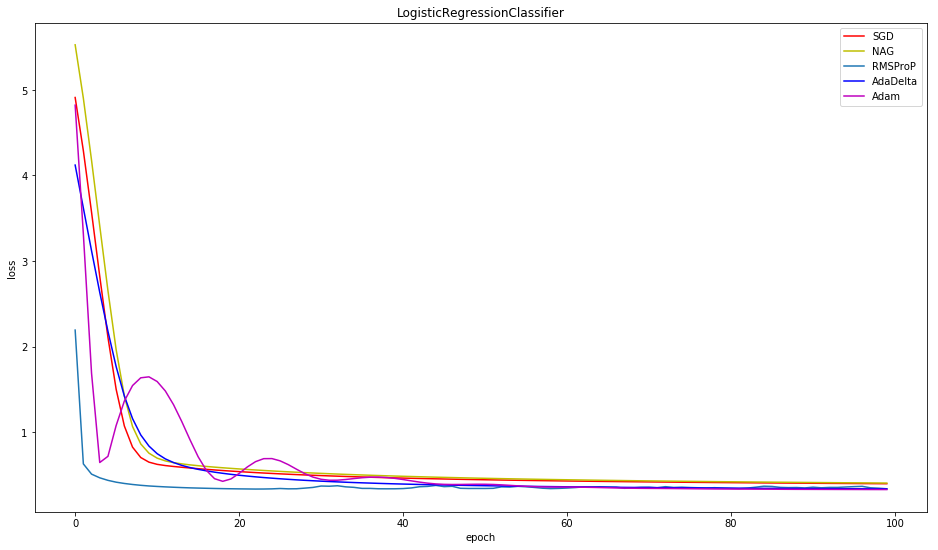

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,9))
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title(optimizers[0].model.__class__.__name__)
for optimizer in optimizers:
    plt.plot(optimizer.model.recorder["validation"], color=optimizer.color, label=optimizer.__class__.__name__)
plt.legend()
plt.show()